# Auditing Bias of Machine Learning Algorithms

In this tutorial, we audit a machine learning model in terms of its fairness property. Our focus is on group fairness, a popular paradigm of fairness notions that try to establish equity in prediction across different demographic groups in the data based on sensitive features: race, gender, etc. By the end of this notebook, the audience will be demonstrated a formal framework for quantifying bias or unfairness in machine learning and a framework to explain bias in terms of participating feature combinations in the data.
- **Formal Quantification of Bias:** We deploy a recently developed formal fairness quantifier `Justicia` to quantify the bias of a machine learning classifier that relies on the probability distribution of features to measure the bias of the classifier. (https://github.com/meelgroup/justicia)
- **Fairness Enhancing Algorithms** We demonstrate to improve unfairness by applying a pre-processing *reweighing*-based fairness algorithms from AIF360, an extensive library of fairness algorithms (https://github.com/ReAILe/bias-explainer)
- **Explaining Sources of Bias:** We rely on a fairness explainer, called `FairXplainer` to decompose the bias of the classifier among unfairness contributions of different combinations of features. (https://github.com/ReAILe/bias-explainer)
- For experiments, we consider recently introduced US census datasets incorporated in a python package `folktables`. The details of the dataset is here: https://github.com/socialfoundations/folktables

In [1]:
# Necessary libraries (see README.md for installation instructions)
from folktables import ACSDataSource, ACSEmployment, generate_categories
import math
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from justicia.metrics import Metric
import aif360
from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.preprocessing.reweighing import Reweighing
from fairxplainer.fair_explainer import FairXplainer
from fairxplainer.fair_explainer import plot as fif_plot
from fairxplainer import utils
from sklearn.metrics import classification_report



fontsize = 22
labelsize = 20



good_name_features = {
        'AGEP' : 'Age',
        'SCHL' : 'Education',
        'MAR' : 'Marital status',
        'RELP' : 'Relationship',
        'DIS' : 'Disability',
        'ESP' : "Parent's employment",
        'CIT' : 'Citizenship',
        'MIG' : 'Mobility status',
        'MIL' : 'Military service',
        'ANC' : 'Ancestry',
        'NATIVITY' : 'Nativity',
        'DEAR' : 'Hearing difficulty',
        'DEYE' : 'Vision difficulty',
        'DREM' : 'Cognitive difficulty',
        'SEX' : 'Sex',
        'RAC1P' : 'Race'
}

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pip install 'aif360[LawSchoolGPA]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'


Get the dataset

In [2]:
data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
definition_df = data_source.get_definitions(download=True)
acs_data = data_source.get_data(states=["AL"], download=True)
features_unscaled, label, group = ACSEmployment.df_to_pandas(acs_data)
categories_ = generate_categories(features=features_unscaled, definition_df=definition_df)
categories = {}
for key in categories_.keys():    
    categories[good_name_features[key]] = categories_[key]
features_unscaled = features_unscaled.rename(columns=good_name_features)

In [3]:
label = label.drop(features_unscaled[features_unscaled['Race'].isin([3, 4, 5, 7, 8])].index)
features_unscaled = features_unscaled.drop(features_unscaled[features_unscaled['Race'].isin([3, 4, 5, 7, 8])].index)
label.reset_index(drop=True, inplace=True)
features_unscaled.reset_index(drop=True, inplace=True)

features_unscaled = features_unscaled.replace({'Race': categories['Race']}) 
features_unscaled = utils.get_one_hot_encoded_df(features_unscaled, ['Race']) 
for key in categories['Race']:
    val = categories['Race'][key]
    categories['Race_' + val] = {1 : 'Yes', 0 : 'No'}
del categories['Race']


Scale dataset

In [4]:
scaler = MinMaxScaler()
features = features_unscaled.copy()
features[features.columns] = scaler.fit_transform(features[features.columns])
features

,Age,Education,Marital status,Relationship,Disability,Parent's employment,Citizenship,Mobility status,Military service,Ancestry,Nativity,Hearing difficulty,Vision difficulty,Cognitive difficulty,Sex,Race_Asian alone,Race_Black or African American alone,Race_Two or More Races,Race_White alone
0,0.204301,0.750000,1.0,1.000000,1.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
1,0.193548,0.750000,1.0,1.000000,1.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.569892,0.708333,1.0,0.941176,0.0,0.000,0.0,0.333333,1.0,0.333333,0.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,1.0
3,0.301075,0.791667,1.0,0.941176,1.0,0.000,0.0,0.333333,0.5,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.268817,0.500000,1.0,0.941176,0.0,0.000,0.0,1.000000,1.0,0.000000,0.0,1.0,1.0,0.5,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47052,0.193548,0.666667,1.0,0.117647,1.0,0.000,0.0,0.333333,1.0,0.000000,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0
47053,0.161290,0.458333,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
47054,0.107527,0.250000,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
47055,0.043011,0.041667,1.0,0.117647,1.0,0.875,0.0,0.333333,0.0,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Interpreting feature values

In [5]:
# mapping categories from unscaled to scaled
assert isinstance(scaler, MinMaxScaler)
categories_scaled = {}

for column in features_unscaled.columns:
    categories_scaled[column] = {}
    idx = list(features_unscaled.columns).index(column)
    if(column not in categories):
        continue
    for key in categories[column].keys():
        if(not math.isnan(key)):
            categories_scaled[column][key * scaler.scale_[idx] + scaler.min_[idx]] = categories[column][key]

Training

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.6, random_state=0)

model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)
yhat = model.predict(X_test)
print(classification_report(y_test, yhat, target_names=['0', '1']))

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.82      0.81      0.81     16586
           1       0.73      0.74      0.74     11649

    accuracy                           0.78     28235
   macro avg       0.77      0.77      0.77     28235
weighted avg       0.78      0.78      0.78     28235



In [7]:
for column in features.columns:
# for column in ['RAC1P']:
    if(column not in categories_scaled): # not a categorical feature
        continue

    if(len(categories_scaled[column]) == 0):
        continue
    
    prediction_probs = {}
    for val in categories_scaled[column]:
        prediction_probs[val] = np.mean(yhat[(y_test.values == 1).ravel() & (X_test[column].values == val)])

    min_val = min(prediction_probs, key=prediction_probs.get)
    max_val = max(prediction_probs, key=prediction_probs.get)

    print(column)
    print(categories_scaled[column][max_val], "vs", categories_scaled[column][min_val])
    print("Statistical parity:", prediction_probs[max_val] - prediction_probs[min_val])
    # print(prediction_probs)
    print()

Education
Professional degree beyond a bachelor's degree vs No schooling completed
Statistical parity: 0.9301310043668122

Marital status
Married vs Widowed
Statistical parity: 0.41268751155284444

Relationship
Foster child vs Parent-in-law
Statistical parity: 1.0

Disability
Without a disability vs With a disability
Statistical parity: 0.6362032462949894

Parent's employment
Both parents in labor force vs Mother only in labor force
Statistical parity: 0.5079365079365079

Citizenship
Born abroad of American parent(s) vs Born in Puerto Rico, Guam, the U.S. Virgin Islands, or the Northern Marianas
Statistical parity: 0.17500000000000004

Mobility status
Yes, same house (nonmovers) vs No, outside US and Puerto Rico
Statistical parity: 0.051347726910124236

Military service
Now on active duty vs Now on active duty
Statistical parity: nan

Ancestry
Unclassified vs Single
Statistical parity: 0.05671344984511828

Nativity
Native vs Foreign born
Statistical parity: 0.00977664813603163

Hearing

/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Formal fairness quantification

In [8]:
justicia_results = []

for sensitive_feature_set in [['Sex'], ['Race'], ['Race', 'Sex']]:

    print("Sensitive features", sensitive_feature_set)
    metric = Metric(model=model, 
                    data=X_test, 
                    sensitive_attributes=sensitive_feature_set, 
                    verbose=False, 
                    encoding="best-correlated",
                    dag_threshold=0.2)
    metric.compute()
    print("Sensitive attributes", metric.given_sensitive_attributes)
    print("Disparate Impact:", metric.disparate_impact_ratio)
    print("Statistical Parity:", metric.statistical_parity_difference)
    print("Time taken", metric.time_taken, "seconds")
    print(metric)
    print()
    justicia_results.append(metric)
    



Sensitive features ['Sex']


KeyboardInterrupt: 

In [ ]:
fa

NameError: name 'fa' is not defined

In [ ]:
for column in features.columns:
    if(column.startswith("Race")):
        print(column, features[column].mean())

Race_Asian alone 0.01181545784899165
Race_Black or African American alone 0.21495207939307648
Race_Two or More Races 0.01774443759695688
Race_White alone 0.755488025160975


In [ ]:
categories_['RAC1P']

{1: 'White alone',
 2: 'Black or African American alone',
 3: 'American Indian alone',
 4: 'Alaska Native alone',
 5: 'American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races',
 6: 'Asian alone',
 7: 'Native Hawaiian and Other Pacific Islander alone',
 8: 'Some Other Race alone',
 9: 'Two or More Races',
 nan: 'N/A'}

## Improving Fairness By a Pre-processing Fairness Algorithm

In [ ]:
encoded_df_train = X_train.copy()
encoded_df_train['target'] = y_train

encoded_df_test = X_test.copy()
encoded_df_test['target'] = y_test


binary_label_dataset_train = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_train,
    label_names=['target'],
    protected_attribute_names=['Sex'])
binary_label_dataset_test = aif360.datasets.BinaryLabelDataset(
    favorable_label=0,
    unfavorable_label=1,
    df=encoded_df_test,
    label_names=['target'],
    protected_attribute_names=['Sex'])


if(False):
    # Disparate Impact Remover
    di = DisparateImpactRemover(repair_level = 1.0)
    di.fit(binary_label_dataset_train)

    dataset_transf_train = di.fit_transform(binary_label_dataset_train).convert_to_dataframe()[0]
    dataset_transf_test = di.fit_transform(binary_label_dataset_test).convert_to_dataframe()[0]


else:
    # Reweighing
    rw = Reweighing(unprivileged_groups=[{'Sex' : 1}], privileged_groups=[{'Sex' : 0}])
    rw.fit(binary_label_dataset_train)

    binary_label_dataset_trans_train = rw.transform(binary_label_dataset_train)
    dataset_transf_train = binary_label_dataset_trans_train.convert_to_dataframe()[0]
    dataset_transf_test = rw.transform(binary_label_dataset_test).convert_to_dataframe()[0]

X_trans_train = dataset_transf_train.drop(['target'], axis = 1)
y_trans_train = dataset_transf_train['target']


X_trans_test = dataset_transf_test.drop(['target'], axis = 1)
y_trans_test = dataset_transf_test['target']



Training after fairness repair

In [ ]:
model_trans = LogisticRegression(solver='lbfgs', max_iter=10000)
model_trans.fit(X_trans_train, y_trans_train, sample_weight= binary_label_dataset_trans_train.instance_weights)

LogisticRegression(max_iter=10000)

Validating fairness repair using Justicia

In [ ]:
metric_trans = Metric(model=model_trans, 
                data=X_trans_test, 
                sensitive_attributes=['Sex'], 
                verbose=True, 
                encoding="best",
                dag_threshold=0.2)
metric_trans.compute()
print("Sensitive attributes", metric_trans.given_sensitive_attributes)
print("Disparate Impact:", metric_trans.disparate_impact_ratio)
print("Statistical Parity:", metric_trans.statistical_parity_difference)
print("Time taken", metric_trans.time_taken, "seconds")
metric_trans

Learn encoding is solved based on Learn-efficient encoding
Expression:  -1 -3 -5 -7 -9 -11 -13 -16 0 2 4 6 8 9 11 13 0 0 -1 -2 -2 0 -1 -2 -3 -3 -4 -5 -6 5 0 -2 -4 -6 -7 -9 -11 -13 0 0 1 1 1 0 0 0 0 0 2 4 6 8 0 0 0 0 -1 -1 -1 0 2 4 -1 2 0 -3 0 0 0 1 0 0 ?= 14
Translation accuracy 0.9479907911259942
Total number of variables in the formula: 72


============================== SubSet-Sum =============

Conditional relations {}
Chance variable [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72]
Choice variable [[63]]
Inner choice variable []
BN parents []
Weights {1: -1, 2: -3, 3: -5, 4: -7, 5: -9, 6: -11, 7: -13, 8: -16, 9: 0, 10: 2, 11: 4, 12: 6, 13: 8, 14: 9, 15: 11, 16: 13, 17: 0, 18: 0, 19: -1, 20: -2, 21: -2, 22: 0, 23: -1, 24: -2, 25: -3, 26: -3, 27: -4, 28: -5, 


Justicia
 - encoding: Learn-efficient
 - model: LogisticRegression(max_iter=10000)
 - given_sensitive_attributes: ['Sex']
 - sensitive_group_statistics: [([('Sex', ('!=', 1.0))], 0.4932920030695118, 72, 0), ([('Sex', ('==', 1.0))], 0.46380887370862167, 72, 0)]
 - given_mediator_attributes: []
 - given_major_group: {}
 - time_taken: 3.867037773132324
 - most_favored_group: {'Sex': ('!=', 1.0)}
 - least_favored_group: {'Sex': ('==', 1.0)}
 - statistical_parity_difference: 0.029483129360890148
 - disparate_impact_ratio: 0.94023189271784

## Explaining the Sources of Bias

In [ ]:
fairXplainer = FairXplainer(model_trans, X_trans_test, ['Sex'])
fairXplainer.compute(maxorder=1, spline_intervals=3, verbose=False, cpu_time=800)

In [ ]:
# result = fairXplainer.get_weights()

# fontsize = 22
# labelsize = 20

# plt = fif_plot(result, 
#                 draw_waterfall=True, 
#                 labelsize=labelsize, 
#                 figure_size=(10,10), 
#                 text_y_pad=0.2, 
#                 xlim=None, 
#                 result_y_location=0.6,
#                 x_label="Influence on " + r"$ \mathsf{SP} $"
#             )
# plt.show()
# plt.clf()
# print("Exact statistical parity", fairXplainer.statistical_parity_sample())

In [ ]:
# k = 15
# result = fairXplainer.get_top_k_weights(k=k)

# plt = fif_plot(result, 
#                draw_waterfall=True, 
#                labelsize=labelsize, 
#                figure_size=(10,10), 
#                text_y_pad=0.2, 
#                xlim=None, 
#                result_x_pad=0.02,
#                x_label="Influence on " + r"$ \mathsf{SP} $"
#         )
# plt.tight_layout()
# plt.show()
# plt.clf()

# print("Exact statistical parity", fairXplainer.statistical_parity_sample())

In [ ]:
def good_name(result):
    result = result.copy()
    good_name_index = []
    for feature_combination in result.index:
        feature_combination_revised = []
        for i, feature in enumerate(feature_combination.split(" & ")):
            feature_combination_revised.append(good_name_features[feature] if feature in good_name_features else feature)
        good_name_index.append(" & ".join(feature_combination_revised))
    print(good_name_index)

    result.index = good_name_index
    return result

['Military service', 'Age', 'Education', 'Cognitive difficulty', 'Relationship', "Parent's employment", 'Mobility status', 'Citizenship', 'Ancestry', 'Marital status', 'Race_American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races', 'Race_Two or More Races', 'Race_Some Other Race alone', 'Race_Native Hawaiian and Other Pacific Islander alone', 'Race_Black or African American alone', 'Others']


/Users/bishwamittraghosh/Desktop/projects/fairness/tutorial/script_tutorial_fairness_auditing/fairxplainer/fair_explainer.py:655: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/Users/bishwamittraghosh/mambaforge-pypy3/envs/fairness_tutorial/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  del sys.path[0]


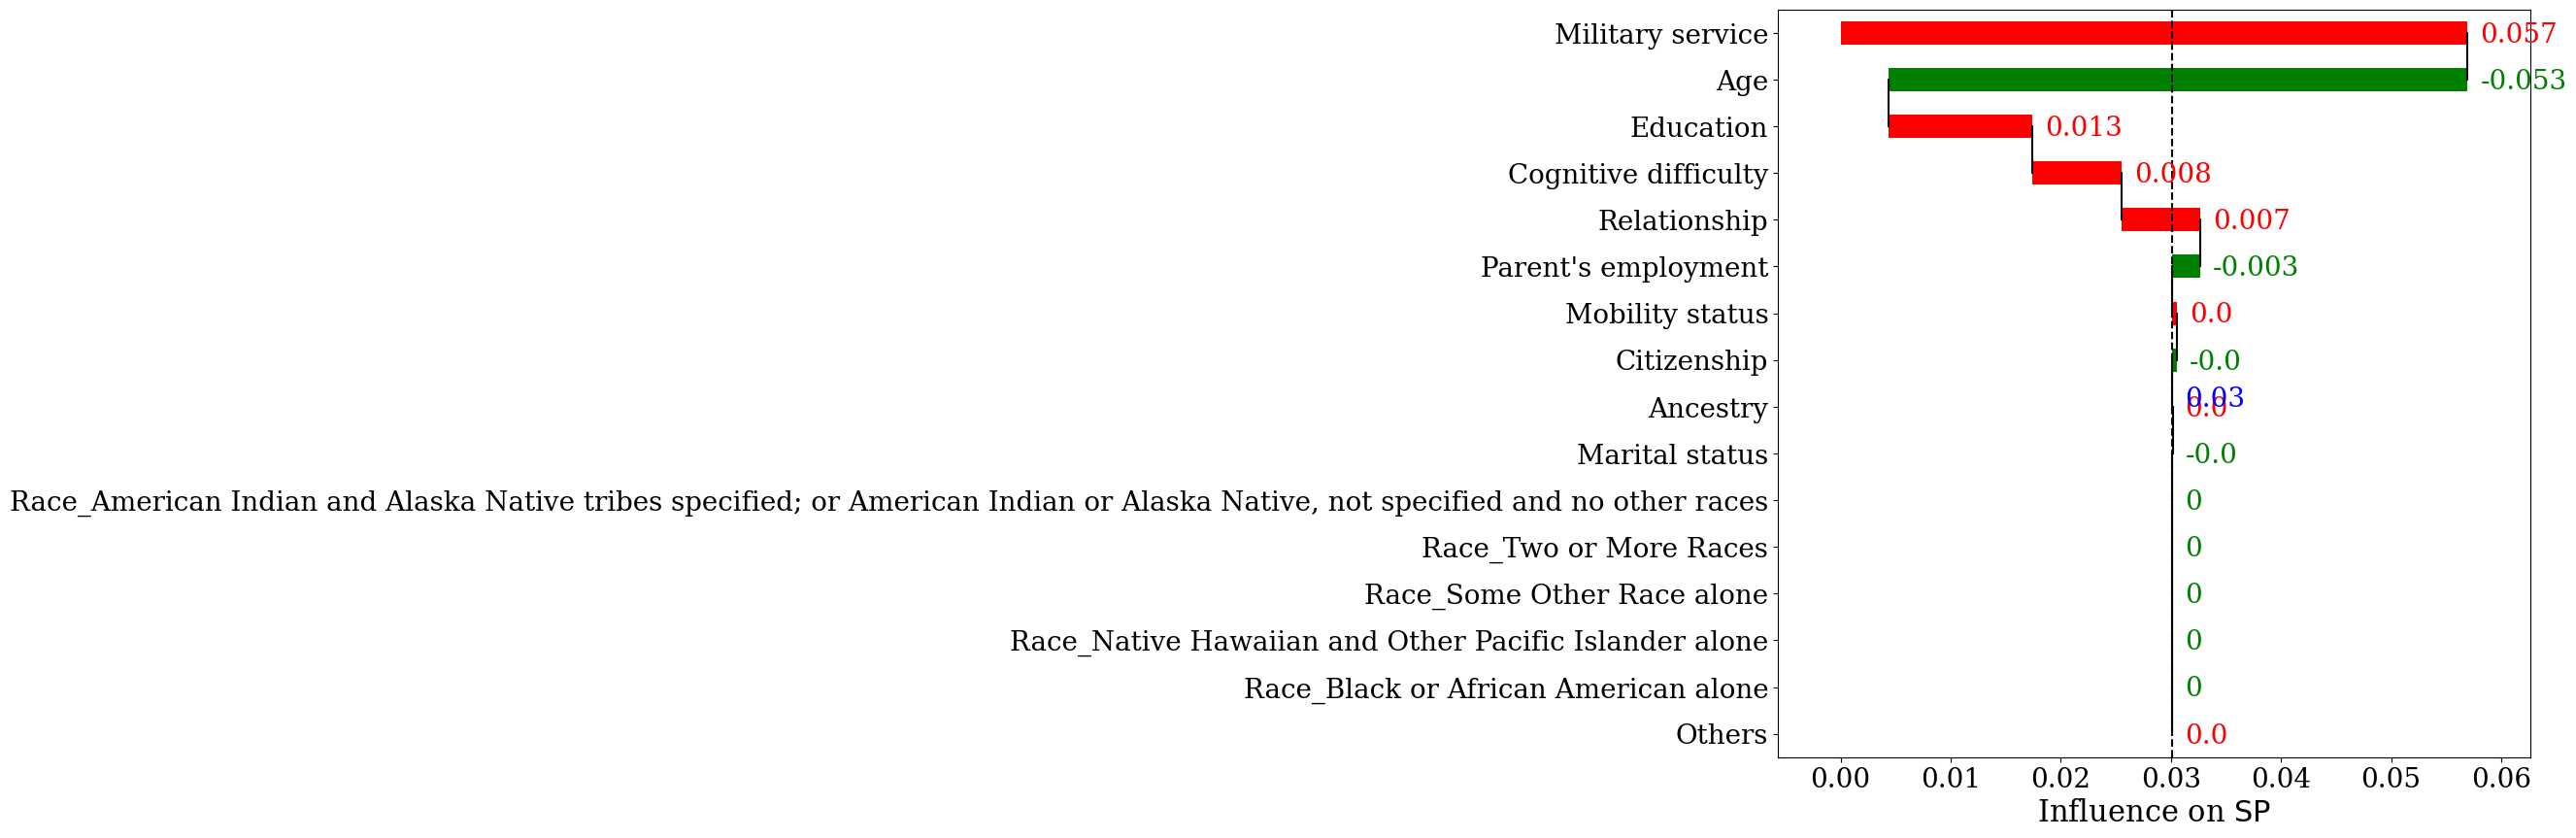

Exact statistical parity 0.028851126726357035


<Figure size 1000x1000 with 0 Axes>

In [ ]:
k = 15
result = fairXplainer.get_top_k_weights(k=k)

plt = fif_plot(good_name(result), 
               draw_waterfall=True, 
               labelsize=labelsize, 
               figure_size=(10,10), 
               text_y_pad=0.2, 
               xlim=None, 
               result_x_pad=0.02,
               x_label="Influence on " + r"$ \mathsf{SP} $"
        )
plt.tight_layout()
plt.show()
plt.clf()

print("Exact statistical parity", fairXplainer.statistical_parity_sample())

In [ ]:
categories_['RAC1P']

{1: 'White alone',
 2: 'Black or African American alone',
 3: 'American Indian alone',
 4: 'Alaska Native alone',
 5: 'American Indian and Alaska Native tribes specified; or American Indian or Alaska Native, not specified and no other races',
 6: 'Asian alone',
 7: 'Native Hawaiian and Other Pacific Islander alone',
 8: 'Some Other Race alone',
 9: 'Two or More Races',
 nan: 'N/A'}